<a href="https://colab.research.google.com/github/rerebebeccacca/20210624-deep-learning-class/blob/main/05face_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 7.4MB/s 


In [4]:
import pickle
import keras
from keras.models import load_model
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from mtcnn import MTCNN
from pprint import pprint

In [5]:
folder_path = '/content/drive/MyDrive/勞動部/03-CNN-Applications/Face_recognition'

In [7]:
# read db
with open(os.path.join(folder_path, 'db.pickle'), 'rb') as file:
    db = pickle.load(file)
embeddings = db['embeddings']
names = db['names']

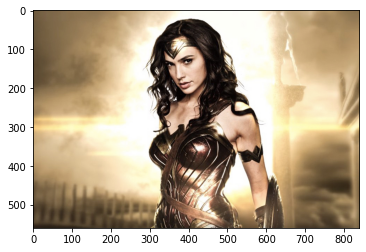

In [8]:
raw_img = cv2.imread(os.path.join(folder_path, 'test_img/face1.jpg'))[:,:,::-1]
plt.imshow(raw_img)

In [9]:
detector = MTCNN()
feature_extractor = load_model(os.path.join(folder_path, 'facenet.h5'))

In [11]:
# detect face
def detect_faces(img):
    face_imgs = []
    results = detector.detect_faces(img)
    # extract the bounding box from the first face
    pprint(f'face count: {len(results)}' )
    pprint(results)
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[y1:y2, x1:x2] # crop face
        face_imgs.append(patch)
    return face_imgs

faces = detect_faces(raw_img)

'face count: 3'
[{'box': [344, 79, 105, 142],
  'confidence': 0.9984662532806396,
  'keypoints': {'left_eye': (353, 139),
                'mouth_left': (370, 192),
                'mouth_right': (408, 184),
                'nose': (369, 174),
                'right_eye': (397, 130)}},
 {'box': [376, 399, 26, 30],
  'confidence': 0.9473415613174438,
  'keypoints': {'left_eye': (387, 408),
                'mouth_left': (384, 420),
                'mouth_right': (389, 421),
                'nose': (391, 416),
                'right_eye': (394, 409)}},
 {'box': [486, 157, 35, 46],
  'confidence': 0.9285464882850647,
  'keypoints': {'left_eye': (501, 172),
                'mouth_left': (504, 190),
                'mouth_right': (517, 190),
                'nose': (514, 180),
                'right_eye': (516, 171)}}]


In [12]:
# all face shapes
for f in faces:
  print(f.shape)

(142, 105, 3)
(30, 26, 3)
(46, 35, 3)


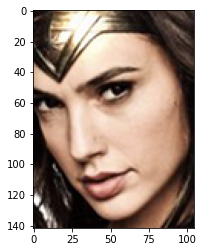

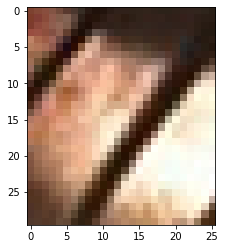

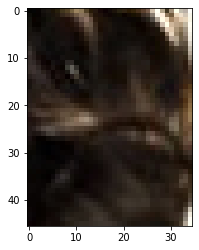

In [13]:
# show all faces
for face in faces:
    plt.imshow(face)
    plt.show()

In [18]:
# Standardization
def preprocess(imgs): 
    for i in range(imgs.shape[0]):
        # standardization
        img = imgs[i]
        mean, std = img.mean(), img.std()
        img = (img - mean) / std
        imgs[i] = img
    return imgs

In [19]:
face = faces[0]
face = cv2.resize(face, (160, 160))
model_input = np.zeros((1, 160, 160, 3))
model_input[0] = face
model_input = preprocess(model_input)
query_embedding = feature_extractor.predict(model_input)
query_embedding.shape

(1, 128)

In [20]:
query_embedding = query_embedding[0]
query_embedding

array([ 0.06799047,  0.12125826,  1.6803017 ,  0.2266227 , -0.19772406,
       -0.5266149 ,  1.3997647 , -1.0153    , -1.004349  , -0.14255561,
       -0.89007926, -0.08877093, -0.850235  ,  0.14866312,  1.7950583 ,
       -0.2586607 , -3.7028863 ,  0.66567945, -1.6760983 , -0.28878063,
        0.6151947 , -1.6937041 ,  1.674318  ,  1.0957053 , -0.55945563,
       -0.845497  , -0.7542733 , -1.3719426 ,  0.831037  ,  1.7763109 ,
        0.8968804 , -0.40917367,  0.24641258,  0.74323225, -0.6018077 ,
       -1.5276098 ,  1.3590082 , -1.5484148 , -0.3125031 , -0.05612363,
        0.5156494 , -0.17581509, -1.0397735 , -0.38326576, -0.43450555,
        1.2091308 ,  0.02058909,  0.89738286, -0.49612463,  0.7863574 ,
       -0.5857703 , -1.1784369 ,  0.5250691 ,  0.9866797 ,  0.8502983 ,
        0.7287936 , -0.3907556 ,  0.445546  ,  0.45927757,  1.4472904 ,
       -0.55583674,  0.23093455,  0.00834765, -0.6252112 , -0.9833476 ,
        0.9170231 , -1.1411942 ,  1.309362  ,  0.8001035 ,  0.38

In [21]:
def euclidean_distance(x, y):
    sum_square = np.sum(np.square(x - y), keepdims=True)
    return np.sqrt(sum_square)

In [23]:
# Get all distances from database embeddings 
distances = np.zeros((len(embeddings)))
for i, embed in enumerate(embeddings):
    distance = euclidean_distance(embed, query_embedding)
    distances[i] = distance

[ 8.55213928 14.27076054 15.66152763 15.79713249 14.56616211]


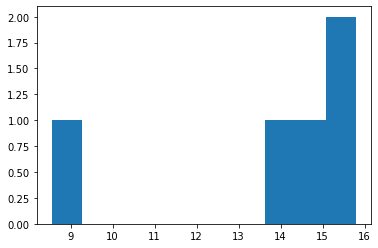

In [24]:
print(distances[:10])
plt.hist(distances)
plt.show()

In [25]:
np.argmin(distances)#第0個人

0

In [26]:
idx_min = np.argmin(distances)
distances[idx_min], names[idx_min]

(8.552139282226562, 'gal_gadot')

In [27]:
def face_id(filename, IMG_SIZE=160):
    raw_img = cv2.imread(os.path.join(folder_path, 'test_img', filename))[:,:,::-1]
    faces = detect_faces(raw_img)
    if len(faces) == 0:
        print('No face')
        return
    else:
        # get face embeddings
        face = faces[0]

        face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        model_input = np.zeros((1, IMG_SIZE, IMG_SIZE, 3))
        model_input[0] = face
        model_input = preprocess(model_input)
        query_embeddings = feature_extractor.predict(model_input)
        query_embedding = query_embeddings[0]
        
        # compute distance
        distances = np.zeros((len(embeddings)))
        for i, embed in enumerate(embeddings):
            distance = euclidean_distance(embed, query_embedding)
            distances[i] = distance
        plt.hist(distances)
        plt.show()
        # find min distance    
        idx_min = np.argmin(distances)
        distance, name = distances[idx_min], names[idx_min]
        print(name, distance)
        plt.imshow(raw_img)
        plt.show()

'face count: 1'
[{'box': [47, 57, 116, 153],
  'confidence': 0.9999666213989258,
  'keypoints': {'left_eye': (63, 118),
                'mouth_left': (76, 173),
                'mouth_right': (127, 159),
                'nose': (76, 140),
                'right_eye': (107, 104)}}]


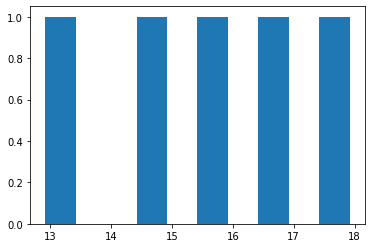

yao-ming 12.919022560119629


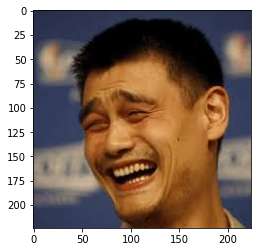

In [33]:
face_id('face9.jpg')